<a href="https://colab.research.google.com/github/KBE25/pneumonia_diagnosis/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

# Business Understanding

Pneumonia remains a devastating global health crisis, particularly for young children. It is the leading infectious cause of death for children under five, claiming over 700,000 lives annually worldwide <a href="https://data.unicef.org/topic/child-health/pneumonia/">[1]</a>. These statistics highlight the urgent demand for swift and accurate diagnostic tools to lessen its impact on children, families, and healthcare systems. In many clinical environments, especially those with limited resources or high patient volumes, medical professionals are often overwhelmed by the sheer number of suspected pneumonia cases. The traditional diagnostic process, which relies on the manual review of chest X-rays by human experts, is time-consuming and can create bottlenecks, leading to delayed diagnoses and critical treatment <a href="https://thepathologist.com/issues/2024/articles/oct/persisting-challenges-in-pneumonia-diagnostics">[2]</a> <a href="https://www.damoreinjurylaw.com/blog/pneumonia-misdiagnosis-conditions-its-mistaken-for-consequences/">[3]</a>.. The goal of building this model is to offer a solution by automating the initial screening of pediatric chest X-rays. This automation frees up experts, allowing them to dedicate their valuable time and specialized knowledge to more complex cases and direct patient care, significantly boosting overall healthcare efficiency. Ultimately, the goal is to deliver a highly effective screening tool that enhances human capabilities, leading to faster diagnoses, more timely treatments, and better health outcomes for children.

The design of our model critically differentiates between types of diagnostic errors. A false positive, where the model incorrectly flags an X-ray for pneumonia, is highly tolerable. This simply means a healthcare worker will review an X-ray that the model flagged but ultimately determines to be clear. Considering that the alternative is for medical professionals to manually examine every X-ray, our system provides a substantial reduction in workload, making this an acceptable trade-off. In contrast, a false negative, where the model misses actual pneumonia, is virtually intolerable. A missed diagnosis can lead to delayed or absent treatment for a serious and rapidly progressing disease, resulting in severe complications, prolonged illness, or even death <a href="https://www.damoreinjurylaw.com/blog/pneumonia-misdiagnosis-conditions-its-mistaken-for-consequences/">[3]</a> <a href="https://timesofindia.indiatimes.com/life-style/health-fitness/health-news/understanding-pneumonia-complications-and-the-risks-of-late-diagnosis/articleshow/107032659.cms">[4]</a>. Therefore, our model's main evaluation metric will be recall above all else, aiming to maximize the identification of true pneumonia cases and minimize the risk of overlooking a child with the disease.

While maximizing recall was our primary goal, we recognized that solely optimizing for it, without considering accuracy, would essentially mean assuming every child had pneumonia and then verifying. This would not reduce the workload. Instead, this model’s design optimizes for both recall and accuracy. After model development and evaluation, we selected the model that achieved the highest recall score while maintaining a robust level of overall accuracy. This balanced approach ensures the model is highly sensitive to the presence of pneumonia, safeguarding against critical false negatives, while still providing a meaningful reduction in the number of X-rays requiring human review.

# Data Understanding

For this analysis, we use a comprehensive collection of X-ray images of children's chests, labeled as 'pneumonia' or 'normal' named <a href="https://data.mendeley.com/datasets/rscbjbr9sj/3">Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images</a> from Mendeley Data.

This dataset is multi-modal, containing both OCT (Optical Coherence Tomography) images of the retina and Chest X-ray images. However, we'll be primarily focusing on the Chest X-Ray component, as the goal of this project is to develop a model to help automate the detection and classification of pneumonia. These X-ray images are highly relevant for training and evaluating our CNN model.

Going into more detail, this dataset comprises 5,863 pediatric chest X-ray images (JPEG format) for pneumonia detection. These images were sourced from the Guangzhou Women and Children's Medical Center and have been rigorously validated by expert physicians. The data is already sorted into a clear folder structure with train, validation, and test sets, each containing NORMAL and PNEUMONIA subfolders. The images are distinctly labeled, making them ideal for training a classification model. A key point to note is that the provided validation set is very limited, containing only 16 images. Due to this small size, we will not be using this data directly and will instead create a new validation set from our training data.

## Data Preparation

Effective data preparation is crucial for training robust deep learning models, especially in medical imaging. Our approach for the pneumonia detection task involves several steps, the first step for data processing will be to import the necessary libraries for this project, download the latest version of the dataset and define the main directories for the data in Colab.


In [1]:
# Import necessary libraries to complete this project
import keras
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [2]:
# Download latest dataset version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Identify the path for the dataset
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
# Define main data directories based on the Colab path
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# List the subdirectories to confirm the classes available within the data
print("Training data classes:", os.listdir(train_dir))
print("Testing data classes:", os.listdir(test_dir))


Training data classes: ['PNEUMONIA', 'NORMAL']
Testing data classes: ['PNEUMONIA', 'NORMAL']


# Exploratory Data Analysis


**Exploratory Data Analysis** in this project will contain the following 4 parts:

  1. ***Class Distribution Analysis***:
    - Purpose: To understand the count of images for each class ('NORMAL' and 'PNEUMONIA') within both the training and test datasets.
    - Importance: This step is vital for identifying potential class imbalances, which can significantly affect model training and lead to biased predictions. Addressing imbalances might involve techniques like oversampling or class weighting.

  2. Sample Image Visualization:
    - Purpose: To visually inspect representative images from both the 'NORMAL' and 'PNEUMONIA' classes.
    - Benefit: Provides an initial qualitative understanding of the data's appearance and helps identify any immediate issues or unique characteristics of the images.

  3. Image Size Analysis:
    - Purpose: To analyze the dimensions of images across the dataset.
    - Importance: Neural networks require consistent input sizes. Given that raw image sizes may vary, this analysis ensures all images are standardized to a uniform square dimension, in this case 256x256 pixels, as expected by the model.

  4. Data Augmentation:
    - Technique: Implementing vertical flipping as a form of data augmentation.
    - Rationale: Vertical flipping is chosen due to its simplicity and the inherent biological plausibility of flipped chest X-ray images, which often maintain anatomical sense, thereby minimally perturbing the structure while expanding the training data variety. This helps the model generalize better to unseen variations.

###1. Class Distribution:

The next step will allow us to see how many images we have in each class ('NORMAL' and 'PNEUMONIA') within the training and test datasets.

This step is important to complete as class imbalances can significanyly affect the model training.


In [5]:
# Function to plot the distribution of 'NORMAL' and 'PNEUMONIA' classes within a specified data directory

def plot_class_distribution(data_dir, title):
  """
    This definition visualizes and prints the number of images belonging to the 'NORMAL' and 'PNEUMONIA' classes within a given directory

    Arguments:
        data_dir (str): The path to the directory containing subdirectories named 'NORMAL' and 'PNEUMONIA'
        title (str): The title to be displayed on the plot and in the print output
    """

  # Construct the paths to the 'NORMAL' and 'PNEUMONIA' subdirectories and count the number of files (images) in each subdirectory
  normal_count = len(os.listdir(os.path.join(data_dir, 'NORMAL')))
  pneumonia_count = len(os.listdir(os.path.join(data_dir, 'PNEUMONIA')))

  # Store the counts and corresponding labels for plotting
  counts = [normal_count, pneumonia_count]
  labels = ['NORMAL', 'PNEUMONIA']

  # Create a figure and axes for the bar plot
  plt.figure(figsize=(8, 6))
  sns.barplot(x=labels, y=counts)
  # Set the title of the plot
  plt.title(f'Class Distribution in {title} Set')
  # Label the y-axis
  plt.ylabel('Number of Images')
  plt.show()

  # Print the class counts for the specified dataset
  print(f"{title} Set: NORMAL - {normal_count}, PNEUMONIA - {pneumonia_count}")


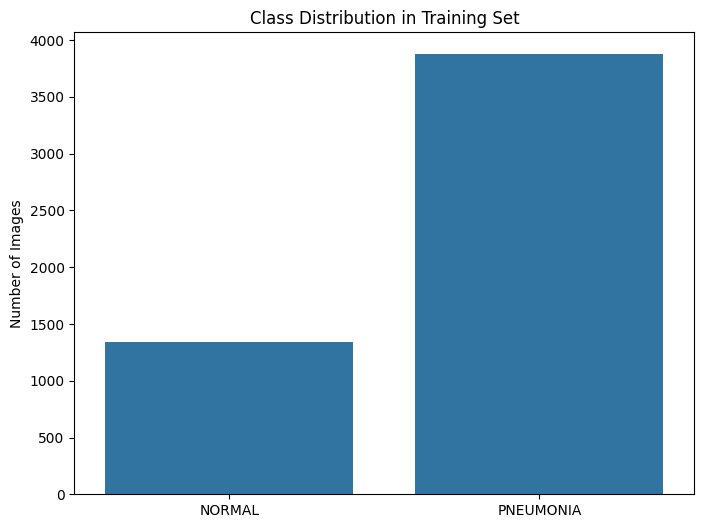

Training Set: NORMAL - 1341, PNEUMONIA - 3875


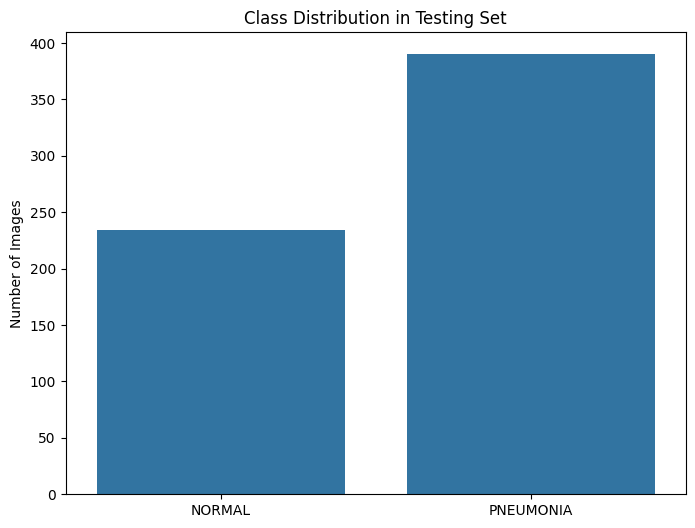

Testing Set: NORMAL - 234, PNEUMONIA - 390


In [6]:
# Call the function to visualize the class distribution for each dataset
plot_class_distribution(train_dir, 'Training')
plot_class_distribution(test_dir, 'Testing')

###2. Sample Images:

We are going to create a function so we can visualize a sample of the images from each class to get a sense of how the data looks like.

In [7]:
# Function to plot a sample of 5 images from each class ('NORMAL' and 'PNEUMONIA') within a specified data directory
def plot_sample_images(data_dir, title):
    """
    Displays a grid of sample images, showing 5 examples of 'NORMAL' and 5 examples of 'PNEUMONIA' images from the given directory

    Arguments:
        data_dir (str): The path to the directory containing subdirectories named 'NORMAL' and 'PNEUMONIA'
        title (str): The title to be displayed above the grid of images
    """
    # Get a list of the first 5 filenames from the 'NORMAL' subdirectory
    normal_files = os.listdir(os.path.join(data_dir, 'NORMAL'))[:5]
    # Get a list of the first 5 filenames from the 'PNEUMONIA' subdirectory
    pneumonia_files = os.listdir(os.path.join(data_dir, 'PNEUMONIA'))[:5]

    # Create a figure and a grid of subplots to display the images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    # Set the title for the entire figure.
    fig.suptitle(f'Sample Images from {title} Set', fontsize=16)

    # Loop through the first 5 'NORMAL' filenames along with their index.
    for i, file in enumerate(normal_files):
        # Construct the full path to the current 'NORMAL' image file
        img_path = os.path.join(data_dir, 'NORMAL', file)
        # Open the image using PIL library
        img = Image.open(img_path)
        # Display the opened image in the i-th column of the first row of subplots
        axes[0, i].imshow(img, cmap='gray')
        # Set the title of the current subplot to 'NORMAL'
        axes[0, i].set_title('NORMAL')
        # Turn off the axis labels and ticks for the current subplot for a cleaner look
        axes[0, i].axis('off')

    # Loop through the first 5 'PNEUMONIA' filenames along with their index
    for i, file in enumerate(pneumonia_files):
        # Construct the full path to the current 'PNEUMONIA' image file
        img_path = os.path.join(data_dir, 'PNEUMONIA', file)
        # Open the image using PIL library
        img = Image.open(img_path)
        # Display the opened image in the i-th column of the second row of subplots
        axes[1, i].imshow(img, cmap='gray')
        # Set the title of the current subplot to 'PNEUMONIA'
        axes[1, i].set_title('PNEUMONIA')
        # Turn off the axis labels and ticks for the current subplot for a cleaner look
        axes[1, i].axis('off')

    # Adjust the layout of the subplots to prevent titles from overlapping.
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

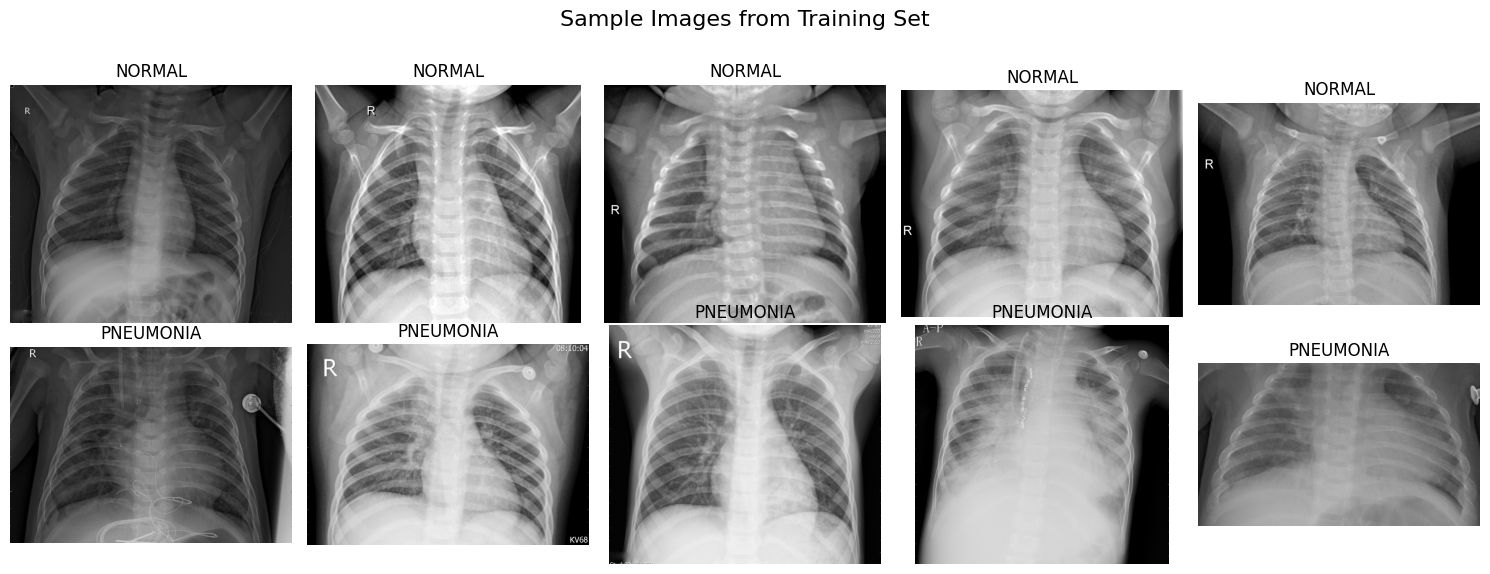

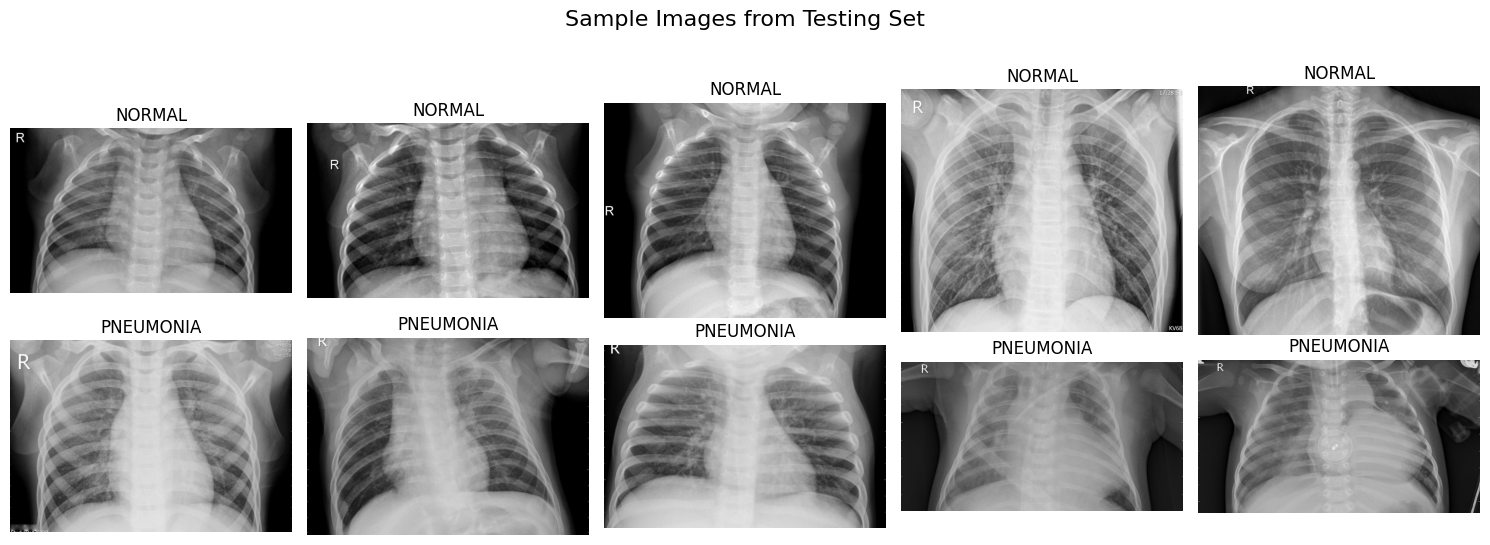

In [8]:
# Call the function to visualize sample images from each dataset
plot_sample_images(train_dir, 'Training')
plot_sample_images(test_dir, 'Testing')

###3. Image Size Analysis:

When using a Neural Network, the model will expect the images to be of consistent square size. Per the above samples, the images size do not seem to be consistent so we are are going so we are now going to analyze the dimensions of the images in the dataset.

In [9]:
# Function to analyze the width and height of images in 'NORMAL' and 'PNEUMONIA'
def analyze_image_sizes(data_dir, title):
    """
    Analyzes the dimensions (width and height) of all images within the 'NORMAL' and 'PNEUMONIA' subdirectories
    It calculates and prints the average, maximum, and minimum width and height

    Arguments:
        data_dir (str): The path to the directory containing 'NORMAL' and 'PNEUMONIA' subdirectories with image files
        title (str): A descriptive title for the dataset being analyzed (e.g., 'Training', 'Validation', 'Testing').
    """
    widths = []  # Create an empty list to store image widths
    heights = [] # Create an empty list to store image heights

    # Iterate through the two class labels: 'NORMAL' and 'PNEUMONIA'
    for label in ['NORMAL', 'PNEUMONIA']:
        # Indicate the path to the directory containing images of the current class
        label_dir = os.path.join(data_dir, label)
        # Iterate through each file in the current class directory
        for file in os.listdir(label_dir):
            try:
                # Construct the full path to the image file
                img_path = os.path.join(label_dir, file)
                # Open the image using PIL library
                img = Image.open(img_path)
                # Get the width and height of the opened image
                width, height = img.size
                # Append the width and height to the empty lists created
                widths.append(width)
                heights.append(height)
            except Exception as e:
                # If an error occurs while processing an image (e.g., corrupted file), print an error message with the file path and the specific error
                print(f"Error processing {img_path}: {e}")

    # After processing all images, print the analysis results for the current dataset
    print(f"\nImage Size Analysis for {title} Set:")
    print(f"  Average Width: {np.mean(widths):.2f}, Max Width: {np.max(widths)}, Min Width: {np.min(widths)}")
    print(f"  Average Height: {np.mean(heights):.2f}, Max Height: {np.max(heights)}, Min Height: {np.min(heights)}")

    # Return the lists
    return widths, heights

In [10]:
# Call the function to analyze image sizes for each dataset
train_widths, train_heights = analyze_image_sizes(train_dir, 'Training')
test_widths, test_heights = analyze_image_sizes(test_dir, 'Testing')


Image Size Analysis for Training Set:
  Average Width: 1320.61, Max Width: 2916, Min Width: 384
  Average Height: 968.07, Max Height: 2663, Min Height: 127

Image Size Analysis for Testing Set:
  Average Width: 1388.13, Max Width: 2752, Min Width: 728
  Average Height: 991.71, Max Height: 2713, Min Height: 344


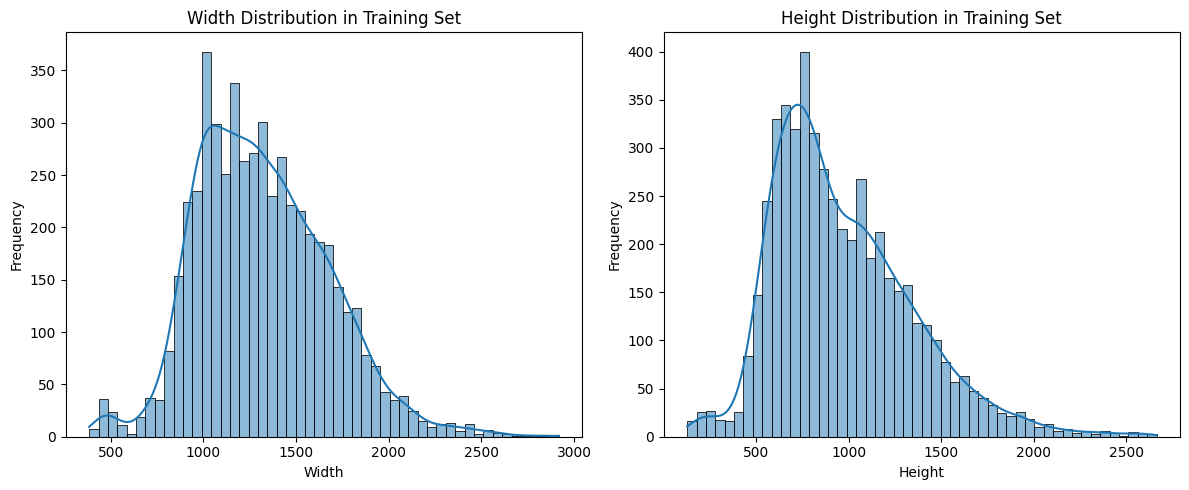

In [11]:
# Create a figure with two subplots for width and height distributions
plt.figure(figsize=(12, 5))

# First subplot for the distribution of image widths using an histogram plot
plt.subplot(1, 2, 1)
sns.histplot(train_widths, bins=50, kde=True)
# Title of the first subplot
plt.title(f'Width Distribution in Training Set')
# Label the x-axis and the y-axis of the first subplot.
plt.xlabel('Width')
plt.ylabel('Frequency')

# Second subplot for the distribution of image heights using an histogram plot
plt.subplot(1, 2, 2)
sns.histplot(train_heights, bins=50, kde=True)
# Set the title of the second subplot
plt.title(f'Height Distribution in Training Set')
# Label the x-axis and the y-axis of the second subplot.
plt.xlabel('Height')
plt.ylabel('Frequency')

# Adjust the spacing between subplots to prevent overlapping.
plt.tight_layout()
plt.show()


Per the histograms for the width and height of the images in the training set we can learn the following:


*   There is a wide range of dimensions for both the width and the height. The width ranges from roughtly 400-3000 pixels while the height ranges from about 300-2500 pixels which means that the images are not consistently sized.

*   Skewed distribution to the right which means that there more images with smaller to medium dimenstions, there is still a significant number of images that are considerable wider and taller. The presence of very large images can lead to inefficiencies as these can lead to increase computational cost and memory during model training.

*   The most typical dimensions within the trainign set range between 1000-1500 pixels for widdth and 800-1200 pixels for heights.

The histograms reveal significant dimensional variability, so we need to resize the images as Neuro Networks perform best with consisten input sizes.

In [12]:
# Calculating the aspect ratios for the width and height for each image in the training dataset
aspect_ratios_train = np.array(train_widths) / np.array(train_heights)

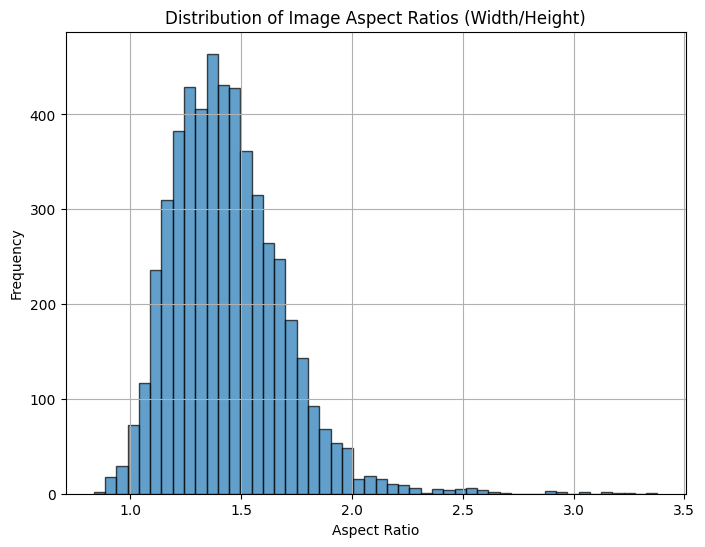

In [13]:
# Create a histogram to analyze the aspect ratios for the training data
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios_train, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Image Aspect Ratios (Width/Height)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
# Add a grid to the plot for better readability
plt.grid(True)
plt.show()

In [14]:
# Calculate median, standard deviation and percentiles for aspect ratios
print(f"\nMedian Aspect Ratio: {np.median(aspect_ratios_train):.2f}")
print(f"Standard Deviation of Aspect Ratio: {np.std(aspect_ratios_train):.2f}")
print(f"Aspect Ratio Percentiles (25th, 50th, 75th): {np.percentile(aspect_ratios_train, [25, 50, 75])}")

# Calculate Percentiles for Widths and Heights
print("\nWidth Percentiles (25th, 50th, 75th):")
print(np.percentile(train_widths, [25, 50, 75]))

print("\nHeight Percentiles (25th, 50th, 75th):")
print(np.percentile(train_heights, [25, 50, 75]))


Median Aspect Ratio: 1.41
Standard Deviation of Aspect Ratio: 0.26
Aspect Ratio Percentiles (25th, 50th, 75th): [1.25747021 1.41170132 1.58341837]

Width Percentiles (25th, 50th, 75th):
[1056. 1284. 1552.]

Height Percentiles (25th, 50th, 75th):
[ 688.    888.   1187.75]


Based on the above information I will consider resizing the images to 256x256 or 512x512.

Considering 256x256 as a resizing target aims for better detail retention by being closer to the original image's peak dimensions. This size balances information preservation with manageable computational costs, aligning with common deep learning practices and potentially aiding transfer learning.

Resizing the images to 512x512 prioritizes maximizing detail retention from the high-resolution original images. This larger size holds the potential for higher accuracy by safeguarding visual cues crucial for accurate diagnoses.

While still involving downsampling, 512x512 is a less aggressive reduction for the large original images. The significant initial resolution suggests that excessive downsampling could lead to the loss of valuable information.

Right now we are going to move ahead with resizing the images to 256x256 as it seems the most optimal size.

In [15]:
# Create an ImageDataGenerator for the training data
# This generator will handle rescaling and splitting the training data into training and validation sets
# rescale: normalize pixel values to the range [0, 1]
# validation_split: reserve 25% of the training data for validation
training_generator = ImageDataGenerator(rescale=1/255, validation_split=0.25)

# Create an ImageDataGenerator for the test data
# We only need to rescale the test data, no validation split is needed
test_generator = ImageDataGenerator(rescale=1/255)

# Create a data generator for the training set
# It reads images from the 'train_dir', resizes them, converts to grayscale,
# assigns binary labels based on subdirectory names, shuffles the data, and yields batches
train_set = training_generator.flow_from_directory(
    train_dir,
    target_size=(256, 256),   # Resize all images to 256x256 pixels
    batch_size=32,             # Process images in batches of 32
    color_mode='grayscale',    # Convert images to grayscale
    class_mode='binary',       # Assume subdirectories contain two classes (e.g., 'NORMAL' and 'PNEUMONIA')
    seed=42,                   # Set a random seed for reproducibility
    subset='training'          # Specify that this generator is for the training subset
)

# Create a data generator for the validation set
# It reads images from the 'train_dir' (the original training directory), resizes them,
# converts to grayscale, assigns binary labels, and yields batches from the validation split
val_set = training_generator.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    seed=42,
    subset='validation'        # Specify that this generator is for the validation subset
)

# Create a data generator for the test set
# It reads images from the 'test_data_dir', resizes them, converts to grayscale,
# assigns binary labels, and yields batches. No subset is specified as it's the entire test set.
test_set = test_generator.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary'
)

# Create the datasets
train_images, train_labels = next(train_set)
val_images, val_labels = next(val_set)
test_images, test_labels = next(test_set)

Found 3913 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
# Print the shapes of the image batches
print("Shape of training images:", train_images.shape)
print("Shape of validation images:", val_images.shape)
print("Shape of test images:", test_images.shape)

# If you also want to see the shape of the labels:
print("Shape of training labels:", train_labels.shape)
print("Shape of validation labels:", val_labels.shape)
print("Shape of test labels:", test_labels.shape)

Shape of training images: (32, 256, 256, 1)
Shape of validation images: (32, 256, 256, 1)
Shape of test images: (32, 256, 256, 1)
Shape of training labels: (32,)
Shape of validation labels: (32,)
Shape of test labels: (32,)


### 4. Data Augmentation

For augmentation we will use vertical flipping as it represents a minimal form of data augmentation, primarily due to its straightforward nature and the inherent symmetries often present in chest X-ray images, rendering the flipped version biologically plausible.

Testing this singular augmentation can be insightful in identifying whether the model has inadvertently learned biases related to the vertical orientation of features within the training dataset. As a result, it serves as a useful, computationally efficient baseline for evaluating the impact of augmentation.

However, it's important to recognize that vertical flipping alone does not provide a comprehensive assessment of the potential benefits of data augmentation, as it lacks the introduction of significant visual variations that other transformations can offer. This is on purpose to keep the risk of overwhelming the model with unrealistic synthetic data through vertical flipping of medical images.

In [17]:
# As we have already created a data generator for the test set in the previous
#part, we do not need to do repeat that step

# Create an ImageDataGenerator for the training data WITH vertical flip
training_generator_aug = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.25,
    vertical_flip=True  # Add vertical flip for augmentation along the Y-axis
)

# Create data generators for the training and validation sets WITH Y-axis flip
train_set_aug = training_generator_aug.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    seed=42,
    subset='training'
)

val_set_aug = training_generator_aug.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    seed=42,
    subset='validation'
)

# Create the datasets WITH Y-axis flip augmentation
train_images_aug, train_labels_aug = next(train_set_aug)
val_images_aug, val_labels_aug = next(val_set_aug)

print("\nShape of training images (Y-axis flip augmentation):", train_images_aug.shape)
print("Shape of training images (Y-axis flip augmentation):", train_labels_aug.shape)
print("Shape of validation images (Y-axis flip augmentation):", val_images_aug.shape)
print("Shape of validation images (Y-axis flip augmentation):", val_labels_aug.shape)


Found 3913 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.

Shape of training images (Y-axis flip augmentation): (32, 256, 256, 1)
Shape of training images (Y-axis flip augmentation): (32,)
Shape of validation images (Y-axis flip augmentation): (32, 256, 256, 1)
Shape of validation images (Y-axis flip augmentation): (32,)


# Modeling

For this project, we will be using a Convolutional Neural Network (CNN) which is a specialized type of artificial neural network primarily designed for processing and analyzing grid-like data, such as images.

As we are using CNNs for this project, choosing the model that yields the best results will take a couple of tries. Since training a model can be time-consuming, we will be saving these models to Kaggle so they do not need to be re-run every time this notebook is executed.

Due to the above reason, the modeling part of this project has the following parts:

1. Creating a connection with Kaggle API: In this part, using my Kaggle API Key, I will be creating a connection to be able to load the models that I have run here and then save to Kaggle. This connection will enable seamless loading and saving of trained models, allowing for efficient evaluation without repeated training.

2. Define functions for model training and evaluation: For this project, we are running 7 different CNN models, so we have defined functions for training and evaluation to make the process more smooth.

3. Training CNN models and evaluation: For each of the 7 different models, we are training the model, saving the model, loading it from Kaggle, and then evaluating the model.

4. Evaluation of models: This part will be done to evaluate all the models that we ran in step (3).

5. Optimization of the model with best results: Based on the best model from step (4), we will run an optimization to determine if we can achieve better results for recall and precision.


## Creating a connection with Kaggle API

The code below is used to create a connection with Kaggle Public API. In this case this connection is done to be able to load the models that I save in Kaggle.

The only change that is needed below is to edit the following part by finding your API token information in your Kaggle account settings part:

*   "username":"ADD_KEY HERE",
*   "key":"ADD_KEY HERE"

***IMPORTANT*** whenever you run the below code, make sure to delete after your 'username' and 'key' as that information is personal and should not be made available in any public site like Github. More information on Kaggle's API can be found <a href="https://www.kaggle.com/docs/api">here</a>.

    
    

In [18]:
import json
import os
from pathlib import Path

# Go to Kaggle and get your API public https://www.kaggle.com/docs/api
api_key = {
    "username":"", #add your Kaggle API username
    "key":""       #add your Kaggle API key
    }

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

#IMPORTANT: after running this code, delete your username and key

## Define functions for model training and evaluation

Below we added two functions that will be recurrently used through modelling to train models and then evaluate them. This will avoid repetion of the code.

In [19]:
# Get input shape
input_shape = (256, 256, 1)

In [20]:
#Function to Train model
# Model train is based on precision, accuracy, recall and binary accuracy
def train_model(model, train_set, val_set, epochs=10, model_name=""):
    """
    Trains the given model and returns the training history
    """
    print(f"\n--- Training {model_name} ---")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'BinaryAccuracy'])
    history = model.fit(
        train_set,
        steps_per_epoch=train_set.samples // train_set.batch_size,
        epochs=epochs,
        validation_data=val_set,
        validation_steps=val_set.samples // val_set.batch_size
    )
    return history


In [21]:
#Function to Evaluate model
def evaluate_model(model, test_set, model_name="", threshold=0.5):
    """
    Evaluates the performance of the given model on the test set,
    printing the classification report, confusion matrix, precision, recall, and F1-score.
    """
    print(f"\n--- Evaluating {model_name} ---")
    predictions_probabilities = model.predict(test_set, steps=test_set.samples // test_set.batch_size)
    predictions = (predictions_probabilities > threshold).astype(int)

    # Ensure we only take as many true labels as we have predictions
    true_labels = test_set.labels[:predictions.shape[0]]

    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=['NORMAL', 'PNEUMONIA']))

    cm = confusion_matrix(true_labels, predictions)
    print("\nConfusion Matrix:")
    print(cm)
    print("TN:", cm[0, 0], "FP:", cm[0, 1], "FN:", cm[1, 0], "TP:", cm[1, 1])

    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Return ket metrics that we will use for evaluation
    return {"precision": precision, "recall": recall, "f1_score": f1, "confusion_matrix": cm}


## Model Training and Evaluation

This section will detail the process of running various CNN model architectures for this project. Our aim is to identify the model that demonstrates the best performance, primarily by maximizing recall while also maintaining high precision. The ultimate goal for the optimal model is to minimize both False Negatives and False Positives.

For each model, the following steps were completed:

1. Model definition
2. Model training
3. Model saving (or "Model is saved")
4. Model loading (or "Model is loaded")
5. Model evaluation

### Model 1: Simple Baseline Model

This Simple Baseline Model is to have a baseline model for comparison.

We designed this model for binary image classification by directly processing raw pixel data. It first flattens the input image into a single, long vector of pixel values. This vector is then fed into a single dense layer with a sigmoid activation. This layer attempts to find a simple linear relationship within the raw pixel data to distinguish between the two classes (e.g., pneumonia vs. normal).

It aims to reduce False Negatives and False Positives by learning a basic linear decision boundary based on the direct pixel intensities. However, its simplicity means it will likely struggle with complex visual patterns, making it less effective at minimizing errors compared to more sophisticated models like CNNs.

In [ ]:
# Simple Baseline Model
def create_simplest_baseline_model(input_shape=(256, 256, 1)):
    """
    Defines the simplest possible baseline model for image classification.
    It flattens the input image and passes it through a single dense layer
    with a sigmoid activation for binary classification.
    """
    model = Sequential([
        Flatten(input_shape=input_shape, name='flatten_input'), # Converts 2D image to 1D vector
        Dense(1, activation='sigmoid', name='output_sigmoid')   # Single output neuron for binary classification
    ])
    return model

To run the model below, you will need to uncomment the simplest_model creation and history training lines by removing the # symbol. These lines are currently commented out because the model has already been run and saved for evaluation in a previous execution.

In [ ]:
"""
To run the model below, you will need to uncomment the simplest_model creation and history training lines by removing the # symbol.
These lines are currently commented out because the model has already been run and saved for evaluation in a previous execution.
"""
#Create the model
#simplest_model = create_simplest_baseline_model()

#Train the model
#history = train_model(simplest_model, train_set_aug, val_set_aug, model_name="Simplest Baseline Model")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Training Simplest Baseline Model ---
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 366ms/step - BinaryAccuracy: 0.7515 - Precision: 0.8315 - Recall: 0.8286 - accuracy: 0.7515 - loss: 1.9338 - val_BinaryAccuracy: 0.6477 - val_Precision: 1.0000 - val_Recall: 0.5248 - val_accuracy: 0.6477 - val_loss: 0.9136
Epoch 2/10
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - BinaryAccuracy: 0.7812 - Precision: 1.0000 - Recall: 0.7200 - accuracy: 0.7812 - loss: 0.4294

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - BinaryAccuracy: 0.7812 - Precision: 1.0000 - Recall: 0.7200 - accuracy: 0.7812 - loss: 0.4294 - val_BinaryAccuracy: 0.8898 - val_Precision: 0.9287 - val_Recall: 0.9219 - val_accuracy: 0.8898 - val_loss: 0.2390
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 354ms/step - BinaryAccuracy: 0.8508 - Precision: 0.8885 - Recall: 0.9094 - accuracy: 0.8508 - loss: 0.4542 - val_BinaryAccuracy: 0.8977 - val_Precision: 0.8996 - val_Recall: 0.9706 - val_accuracy: 0.8977 - val_loss: 0.2520
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - BinaryAccuracy: 0.9062 - Precision: 0.9615 - Recall: 0.9259 - accuracy: 0.9062 - loss: 0.1741 - val_BinaryAccuracy: 0.8867 - val_Precision: 0.8805 - val_Recall: 0.9799 - val_accuracy: 0.8867 - val_loss: 0.2963
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 72s 363ms/step - BinaryAccuracy: 0.9184 - Precision: 0.9410 - Recall: 0.9495 - accuracy: 0.9184 - loss: 0.2408 - val_BinaryAccuracy: 0.9000 - val_Precision: 0.8928 - val_R

In [ ]:
"""
To run the code below, you will need to uncomment the simplest_model.save("simplest_model.h5") by removing the # symbol.
These lines are currently commented out because the model has already been saved in a previous execution.
"""
#Saving the model
#simplest_model.save("simplest_model.h5")

In [22]:
#After saving the model in the previous step
#We upload the model in Kaggle and
#then we download the model from Kaggle to Colab with the below code
! kaggle datasets download -d karinabe25us/simplest-model
! unzip simplest-model.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/simplest-model
License(s): apache-2.0
  0% 0.00/697k [00:00<?, ?B/s]
100% 697k/697k [00:00<00:00, 709MB/s]
Archive:  simplest-model.zip
  inflating: simplest__model.h5      


In [23]:
#Loading the model
simplest_model = keras.models.load_model('simplest__model.h5')

In [24]:
#Evaluate the loaded and trained model
evaluation_results = evaluate_model(simplest_model, test_set, model_name="Simplest Baseline Model")


--- Evaluating Simplest Baseline Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.42      0.11      0.17       234
   PNEUMONIA       0.62      0.91      0.74       374

    accuracy                           0.60       608
   macro avg       0.52      0.51      0.45       608
weighted avg       0.54      0.60      0.52       608


Confusion Matrix:
[[ 25 209]
 [ 34 340]]
TN: 25 FP: 209 FN: 34 TP: 340

Precision: 0.6193
Recall: 0.9091
F1-Score: 0.7367


Based on the above results I get the following results:
Poor Performance for "NORMAL" class: The model struggles significantly with

*   The model struggles to identify "NORMAL" cases. Based on the above information, the data has 234 "NORMAL" and the model only predicts this 42% of the time.
*   The model has a decent performance when identifying "PNEUMONIA" cases. Per the metrics, the model has a precision of 62% which is the number of times the model predicts "PNEUMONIA" correctly. Additionally, the model has a recall of 0.91 which means that 91% of the times the model correctly identifies "PNEUMONIA"
*   The model also has the following results:

  1.   Overall Accuracy (0.60): While appearing moderate, this metric is misleading due to significant performance differences between the "NORMAL" and "PNEUMONIA" classes.

  2. Macro Averages (P: 0.52 / R: 0.51 / F1: 0.45): These unweighted averages are low, highlighting the model's poor performance on one or more classes, specifically the "NORMAL" class.
  3. Weighted Averages (P: 0.54 / R: 0.60 / F1: 0.52): These averages, considering class support, are slightly higher than macro averages but still indicate overall relatively low performance, particularly reflecting the struggle with the minority class.

Due to the problem we are trying to resolve, the goal of the model should be to minimize False Negatives (FN), this means we want to minimize the number of times that the model incorrectly identifies a normal X-ray. The reason is that a missed case of pneumonia can have direct, severe, and potentially life-threatening health consequences for the patient. Based on the confusion matrix I can see that the model already achieves the following:

*   The model has a Recall of 0.91 for the PNEUMONIA class, which is already quite high. This means it's already doing a good job of minimizing False Negatives. Out of 374 actual pneumonia cases, it only missed 34 (FN = 34)
*   The model has a very high number of False Positives (FP = 209), meaning it frequently misclassifies normal cases as pneumonia. This is reflected in the low Precision for the NORMAL class (0.42) and the PNEUMONIA class (0.62)

Then as next steps I'm going to first run this baseline model with augmented data to see if the outcome is better and then after that I will work on a second model more lenient on in predicting pneumonia.



### Simple Baseline Model with Augmentation

This model utilizes the identical architecture of the previously evaluated Simple Baseline Model. However, it is trained with the augmented dataset, rather than the original data, to investigate whether data augmentation enhances the model's generalization capabilities and predictive performance.

In [ ]:
"""
To run the model below, you will need to uncomment the simplest_model_aug creation and history_aug training lines by removing the # symbol.
These lines are currently commented out because the model has already been run and saved for evaluation in a previous execution.
"""

#Create the model with augmentation
#simplest_model_aug = create_simplest_baseline_model()

# Train the model
#history_aug = train_model(simplest_model_aug, train_set_aug, val_set_aug, model_name="Augmented Simplest Baseline Model")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Training Augmented Simplest Baseline Model ---
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 367ms/step - BinaryAccuracy: 0.7420 - Precision: 0.8166 - Recall: 0.8388 - accuracy: 0.7420 - loss: 1.8627 - val_BinaryAccuracy: 0.8859 - val_Precision: 0.8785 - val_Recall: 0.9821 - val_accuracy: 0.8859 - val_loss: 0.3024
Epoch 2/10
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - BinaryAccuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0492

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - BinaryAccuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0492 - val_BinaryAccuracy: 0.8930 - val_Precision: 0.9358 - val_Recall: 0.9190 - val_accuracy: 0.8930 - val_loss: 0.2467
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 675ms/step - BinaryAccuracy: 0.8877 - Precision: 0.9227 - Recall: 0.9245 - accuracy: 0.8877 - loss: 0.3066 - val_BinaryAccuracy: 0.8891 - val_Precision: 0.9551 - val_Recall: 0.8929 - val_accuracy: 0.8891 - val_loss: 0.2862
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - BinaryAccuracy: 0.9688 - Precision: 1.0000 - Recall: 0.9583 - accuracy: 0.9688 - loss: 0.0842 - val_BinaryAccuracy: 0.8953 - val_Precision: 0.9514 - val_Recall: 0.9054 - val_accuracy: 0.8953 - val_loss: 0.2554
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 142s 844ms/step - BinaryAccuracy: 0.9289 - Precision: 0.9484 - Recall: 0.9572 - accuracy: 0.9289 - loss: 0.1825 - val_BinaryAccuracy: 0.8820 - val_Precision: 0.9807 - val_

In [ ]:
"""
To run the code below, you will need to uncomment the simplest_model_aug.save("simplest_model_aug.h5") by removing the # symbol.
These lines are currently commented out because the model has already been saved in a previous execution.
"""

#Saving the model
#simplest_model_aug.save("simplest_model_aug.h5")

In [25]:
#Loading the model that I saved above from Kaggle
! kaggle datasets download -d karinabe25us/simplest-model-aug
! unzip simplest-model-aug.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/simplest-model-aug
License(s): apache-2.0
  0% 0.00/696k [00:00<?, ?B/s]
100% 696k/696k [00:00<00:00, 681MB/s]
Archive:  simplest-model-aug.zip
  inflating: simplest_model_aug.h5   


In [26]:
#Loading the model
simplest_model_aug = keras.models.load_model('simplest_model_aug.h5')

In [27]:
#Evaluate the loaded and trained model
evaluation_results_aug = evaluate_model(simplest_model_aug, test_set, model_name="Augmented Simplest Baseline Model")


--- Evaluating Augmented Simplest Baseline Model ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.34      0.18      0.24       234
   PNEUMONIA       0.60      0.78      0.68       374

    accuracy                           0.55       608
   macro avg       0.47      0.48      0.46       608
weighted avg       0.50      0.55      0.51       608


Confusion Matrix:
[[ 43 191]
 [ 83 291]]
TN: 43 FP: 191 FN: 83 TP: 291

Precision: 0.6037
Recall: 0.7781
F1-Score: 0.6799


In medical diagnosis (like pneumonia), minimizing False Negatives (missing a disease) is usually the most important goal for the model. A doctor would rather have a few false alarms (FP) that require further investigation than miss a critical diagnosis (FN).

The current "Augmented" model reduces the number of False Positives to only 191 vs 209 in the previous model, but at the cost of increasing False Negatives (34 in the previous model vs 83 in the augmented model). This suggests that the augmentation might have made the model more conservative in predicting pneumonia, or it found patterns that led to better normal classification but at the expense of pneumonia recall. Therefore, from a purely clinical standpoint the non-augmented (or original) model was 'better' because of its much higher recall for the PNEUMONIA class (0.91 vs 0.78).

Therefore, in the following parts we are just going to evaluated the non augmented data and look for a model more lenient on predicting pneumonia while keeping FNs low and helping reduce the number of FPs.

## CNN Baseline Model

This CNN model learns to classify X-ray images by extracting increasingly complex visual features through its Conv2D and MaxPooling2D layers. These layers identify patterns differentiating pneumonia from normal X-rays. The subsequent Flatten and Dense layers then take these learned features to make a final prediction.

The model's primary goal is to minimize both False Negatives and False Positives by optimizing its ability to correctly distinguish between the two classes. It produces a probability score via a sigmoid activation for binary classification. This is a baseline approach that relies on effective feature learning to reduce classification errors.

In [ ]:
#Model Definition
def create_cnn_baseline_model(input_shape=(256, 256, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
#Create the model
#cnn_baseline = create_cnn_baseline_model()

#Train the model
#history_cnn = train_model(cnn_baseline, train_set, val_set, model_name="CNN Baseline Model")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training CNN Baseline Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 762s 6s/step - BinaryAccuracy: 0.7663 - Precision: 0.8257 - Recall: 0.8573 - accuracy: 0.7663 - loss: 0.5853 - val_BinaryAccuracy: 0.9187 - val_Precision: 0.9690 - val_Recall: 0.9201 - val_accuracy: 0.9187 - val_loss: 0.2135
Epoch 2/10
  1/122 ━━━━━━━━━━━━━━━━━━━━ 7:55 4s/step - BinaryAccuracy: 0.9375 - Precision: 1.0000 - Recall: 0.9167 - accuracy: 0.9375 - loss: 0.1491

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


122/122 ━━━━━━━━━━━━━━━━━━━━ 90s 709ms/step - BinaryAccuracy: 0.9375 - Precision: 1.0000 - Recall: 0.9167 - accuracy: 0.9375 - loss: 0.1491 - val_BinaryAccuracy: 0.9211 - val_Precision: 0.9692 - val_Recall: 0.9234 - val_accuracy: 0.9211 - val_loss: 0.2053
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 717s 6s/step - BinaryAccuracy: 0.9617 - Precision: 0.9745 - Recall: 0.9733 - accuracy: 0.9617 - loss: 0.1016 - val_BinaryAccuracy: 0.9320 - val_Precision: 0.9954 - val_Recall: 0.9125 - val_accuracy: 0.9320 - val_loss: 0.1815
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 83s 652ms/step - BinaryAccuracy: 0.9688 - Precision: 1.0000 - Recall: 0.9615 - accuracy: 0.9688 - loss: 0.0513 - val_BinaryAccuracy: 0.9109 - val_Precision: 0.9976 - val_Recall: 0.8825 - val_accuracy: 0.9109 - val_loss: 0.2387
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 681s 5s/step - BinaryAccuracy: 0.9721 - Precision: 0.9822 - Recall: 0.9803 - accuracy: 0.9721 - loss: 0.0765 - val_BinaryAccuracy: 0.9586 - val_Precision: 0.9807 - val_Reca

In [ ]:
#Saving the model
#cnn_baseline.save("cnn_baseline.h5")

In [63]:
#Loading the model that I saved above from Kaggle
! kaggle datasets download -d karinabe25us/cnn-baseline
! unzip cnn-baseline.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/cnn-baseline
License(s): apache-2.0
 77% 100M/130M [00:00<00:00, 1.05GB/s]
100% 130M/130M [00:00<00:00, 932MB/s] 
Archive:  cnn-baseline.zip
  inflating: cnn_baseline.h5         


In [64]:
#Loading the model
cnn_baseline = keras.models.load_model('cnn_baseline.h5')

In [65]:
#Evaluate the trained model
evaluation_results_cnn= evaluate_model(cnn_baseline, test_set, model_name="CNN Baseline Model")


--- Evaluating CNN Baseline Model ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.32      0.17      0.22       234
   PNEUMONIA       0.60      0.77      0.67       374

    accuracy                           0.54       608
   macro avg       0.46      0.47      0.45       608
weighted avg       0.49      0.54      0.50       608


Confusion Matrix:
[[ 40 194]
 [ 85 289]]
TN: 40 FP: 194 FN: 85 TP: 289

Precision: 0.5983
Recall: 0.7727
F1-Score: 0.6744


This model achieved an overall accuracy of 57%. While it shows reasonable recall (79%) for "PNEUMONIA," correctly identifying many cases, it still yielded 78 False Negatives. This means 78 actual pneumonia cases were missed and incorrectly classified as normal, which is a serious concern in a medical context, potentially leading to delayed or absent treatment. Furthermore, the model performs poorly on "NORMAL" cases with only 21% recall and a high 186 False Positives, falsely identifying normal X-rays as pneumonia. This stark imbalance and the significant number of missed pneumonia cases suggest the model is overfitting to the "PNEUMONIA" class, failing to generalize well and correctly identify both conditions.

## Regularized CNN Model

This adjusted CNN model effectively identifies X-rays with pneumonia by first extracting hierarchical features from the images using convolutional and pooling layers. Its key improvement lies in preventing overfitting through strategic Dropout layers, which are crucial for generalization, especially with smaller or noisy datasets. By randomly deactivating connections during training, the model is forced to learn robust patterns, rather than simply memorizing the training data.

Finally, a Dense layer with sigmoid activation provides a clear probability score, indicating the likelihood of pneumonia in a given X-ray, making the model reliable for clinical assessment.

In [ ]:
def create_regularization_cnn_model(input_shape=(256, 256, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25), # Example: add dropout
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25), # Example: add dropout
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25), # Example: add dropout
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5), # Example: add dropout before final dense
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
#Create the model
#cnn_regularization = create_regularization_cnn_model()

#Train the model
#history_regularization = train_model(cnn_regularization, train_set, val_set, model_name="CNN Regularization Model")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training CNN Regularization Model ---
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 682s 6s/step - BinaryAccuracy: 0.7391 - Precision: 0.7756 - Recall: 0.9121 - accuracy: 0.7391 - loss: 0.9985 - val_BinaryAccuracy: 0.9141 - val_Precision: 0.9286 - val_Recall: 0.9579 - val_accuracy: 0.9141 - val_loss: 0.2098
Epoch 2/10
  1/122 ━━━━━━━━━━━━━━━━━━━━ 8:36 4s/step - BinaryAccuracy: 0.9062 - Precision: 0.9286 - Recall: 0.9630 - accuracy: 0.9062 - loss: 0.1449

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 641ms/step - BinaryAccuracy: 0.9062 - Precision: 0.9286 - Recall: 0.9630 - accuracy: 0.9062 - loss: 0.1449 - val_BinaryAccuracy: 0.9219 - val_Precision: 0.9590 - val_Recall: 0.9348 - val_accuracy: 0.9219 - val_loss: 0.1942
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 681s 6s/step - BinaryAccuracy: 0.9248 - Precision: 0.9471 - Recall: 0.9514 - accuracy: 0.9248 - loss: 0.1847 - val_BinaryAccuracy: 0.9453 - val_Precision: 0.9527 - val_Recall: 0.9747 - val_accuracy: 0.9453 - val_loss: 0.1547
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 62s 479ms/step - BinaryAccuracy: 0.9375 - Precision: 1.0000 - Recall: 0.9200 - accuracy: 0.9375 - loss: 0.1676 - val_BinaryAccuracy: 0.9391 - val_Precision: 0.9406 - val_Recall: 0.9801 - val_accuracy: 0.9391 - val_loss: 0.1585
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 706s 5s/step - BinaryAccuracy: 0.9511 - Precision: 0.9570 - Recall: 0.9785 - accuracy: 0.9511 - loss: 0.1180 - val_BinaryAccuracy: 0.9211 - val_Precision: 0.9139 - val_Reca

In [ ]:
#Saving the model
#cnn_regularization.save("cnn_regularization.h5")

In [66]:
#Loading the model that I saved above from Kaggle
! kaggle datasets download -d karinabe25us/cnn-regularization
! unzip cnn-regularization.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/cnn-regularization
License(s): apache-2.0
 67% 103M/153M [00:00<00:00, 1.07GB/s]
100% 153M/153M [00:00<00:00, 354MB/s] 
Archive:  cnn-regularization.zip
  inflating: cnn_regularization.h5   


In [67]:
#Loading the model
cnn_regularization = keras.models.load_model('cnn_regularization.h5')

In [68]:
#Evaluate the trained model
evaluation_results_regularization= evaluate_model(cnn_regularization, test_set, model_name="CNN Regularization Model")


--- Evaluating CNN Regularization Model ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.39      0.18      0.24       234
   PNEUMONIA       0.62      0.83      0.71       374

    accuracy                           0.58       608
   macro avg       0.50      0.50      0.47       608
weighted avg       0.53      0.58      0.53       608


Confusion Matrix:
[[ 41 193]
 [ 64 310]]
TN: 41 FP: 193 FN: 64 TP: 310

Precision: 0.6163
Recall: 0.8289
F1-Score: 0.7070


## CNN with Batch Normalization

Similar to the other models, this model first extracts hierarchical features using Conv2D and MaxPooling2D layers. However, the crucial addition of Batch Normalization (BN) layers after each convolutional block and before the final dense layer stabilizes the training process. This normalization reduces "internal covariate shift," allowing for faster training with higher learning rates and acting as a mild regularization technique. By improving training stability and providing this regularization, the model becomes less prone to overfitting, which in turn helps it generalize better to new data, leading to a more effective reduction of both False Negatives (missed cases) and False Positives (false alarms) in its final probability-based classification.

In [ ]:
def create_bn_cnn_model(input_shape=(256, 256, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(), # Add Batch Normalization
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(), # Add Batch Normalization
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(), # Add Batch Normalization
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(), # Add Batch Normalization
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
#Create the model
#cnn_normalization = create_bn_cnn_model()

#Train the model
#history_normalization = train_model(cnn_normalization, train_set, val_set, model_name="CNN with Batch Normalization Model")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training CNN with Batch Normalization Model ---
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 938s 8s/step - BinaryAccuracy: 0.9066 - Precision: 0.9804 - Recall: 0.8911 - accuracy: 0.9066 - loss: 0.2600 - val_BinaryAccuracy: 0.7445 - val_Precision: 0.7445 - val_Recall: 1.0000 - val_accuracy: 0.7445 - val_loss: 21.3755
Epoch 2/10
  1/122 ━━━━━━━━━━━━━━━━━━━━ 15:10 8s/step - BinaryAccuracy: 0.9375 - Precision: 1.0000 - Recall: 0.9286 - accuracy: 0.9375 - loss: 0.2531

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 522ms/step - BinaryAccuracy: 0.9375 - Precision: 1.0000 - Recall: 0.9286 - accuracy: 0.9375 - loss: 0.2531 - val_BinaryAccuracy: 0.7437 - val_Precision: 0.7437 - val_Recall: 1.0000 - val_accuracy: 0.7437 - val_loss: 19.9633
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 922s 8s/step - BinaryAccuracy: 0.9758 - Precision: 0.9848 - Recall: 0.9823 - accuracy: 0.9758 - loss: 0.0905 - val_BinaryAccuracy: 0.7414 - val_Precision: 0.7414 - val_Recall: 1.0000 - val_accuracy: 0.7414 - val_loss: 5.1011
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 519ms/step - BinaryAccuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0344 - val_BinaryAccuracy: 0.7414 - val_Precision: 0.7414 - val_Recall: 1.0000 - val_accuracy: 0.7414 - val_loss: 5.2536
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 922s 8s/step - BinaryAccuracy: 0.9804 - Precision: 0.9888 - Recall: 0.9850 - accuracy: 0.9804 - loss: 0.0650 - val_BinaryAccuracy: 0.5648 - val_Precision: 0.7872 - val_Rec

In [ ]:
#Saving the model
#cnn_normalization.save("cnn_normalization.h5")

In [69]:
#Loading the model that I saved above from Kaggle
! kaggle datasets download -d karinabe25us/cnn-normalization
! unzip cnn-normalization.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/cnn-normalization
License(s): apache-2.0
 64% 102M/160M [00:00<00:00, 1.06GB/s]
100% 160M/160M [00:00<00:00, 506MB/s] 
Archive:  cnn-normalization.zip
  inflating: cnn_normalization.h5    


In [70]:
#Loading the model
cnn_normalization = keras.models.load_model('cnn_normalization.h5')

In [71]:
#Evaluate the trained model
evaluation_results_normalization= evaluate_model(cnn_normalization, test_set, model_name="CNN with Batch Normalization Model")


--- Evaluating CNN with Batch Normalization Model ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.76       374

    accuracy                           0.62       608
   macro avg       0.31      0.50      0.38       608
weighted avg       0.38      0.62      0.47       608


Confusion Matrix:
[[  0 234]
 [  0 374]]
TN: 0 FP: 234 FN: 0 TP: 374

Precision: 0.6151
Recall: 1.0000
F1-Score: 0.7617


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## CNN Earlystopping

In [50]:
def create_enhanced_cnn_model(input_shape=(256, 256, 1)):
    model = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'), # Third Conv2D layer
        layers.MaxPooling2D((2, 2)), # Corresponding MaxPooling
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [51]:
#Create the model
#cnn_earlystopping = create_enhanced_cnn_model()

#Train the model
#history_earlystopping = train_model(cnn_earlystopping, train_set, val_set, model_name="CNN with early stopping Model")


--- Training CNN with early stopping Model ---
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 515s 4s/step - BinaryAccuracy: 0.8088 - Precision: 0.8291 - Recall: 0.9401 - accuracy: 0.8088 - loss: 0.5034 - val_BinaryAccuracy: 0.8664 - val_Precision: 0.9924 - val_Recall: 0.8261 - val_accuracy: 0.8664 - val_loss: 0.3267
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 652ms/step - BinaryAccuracy: 0.8750 - Precision: 1.0000 - Recall: 0.8000 - accuracy: 0.8750 - loss: 0.2206 - val_BinaryAccuracy: 0.9031 - val_Precision: 0.9858 - val_Recall: 0.8816 - val_accuracy: 0.9031 - val_loss: 0.2411
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 534s 4s/step - BinaryAccuracy: 0.9561 - Precision: 0.9700 - Recall: 0.9710 - accuracy: 0.9561 - loss: 0.1231 - val_BinaryAccuracy: 0.9375 - val_Precision: 0.9513 - val_Recall: 0.9653 - val_accuracy: 0.9375 - val_loss: 0.1434
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 81s 642ms/step - BinaryAccuracy: 0.9688 - Precision: 1.0000 - Recall: 0.9474 - accuracy: 0.9688 - loss: 0.0845 - va

In [52]:
#Saving the model
#cnn_earlystopping.save("cnn_earlystopping.h5")

In [72]:
#Loading the model that I saved above from Kaggle
! kaggle datasets download -d karinabe25us/cnn-earlystopping
! unzip cnn-earlystopping.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/cnn-earlystopping
License(s): apache-2.0
  0% 0.00/35.1M [00:00<?, ?B/s]
100% 35.1M/35.1M [00:00<00:00, 993MB/s]
Archive:  cnn-earlystopping.zip
  inflating: cnn_earlystopping.h5    


In [73]:
#Loading the model
cnn_earlystopping = keras.models.load_model('cnn_earlystopping.h5')

In [74]:
#Evaluate the trained model
evaluation_results_earlystopping = evaluate_model(cnn_earlystopping, test_set, model_name="CNN with early stopping Model")


--- Evaluating CNN with early stopping Model ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.40      0.11      0.17       234
   PNEUMONIA       0.62      0.90      0.73       374

    accuracy                           0.59       608
   macro avg       0.51      0.50      0.45       608
weighted avg       0.53      0.59      0.52       608


Confusion Matrix:
[[ 26 208]
 [ 39 335]]
TN: 26 FP: 208 FN: 39 TP: 335

Precision: 0.6169
Recall: 0.8957
F1-Score: 0.7306


## Advanced CNN

In [53]:
def create_advanced_model_v2(input_shape=(256, 256, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'),
        BatchNormalization(name='batchnorm1'),
        MaxPooling2D((2, 2), name='pool1'),
        Conv2D(64, (3, 3), activation='relu', name='conv2'),
        BatchNormalization(name='batchnorm2'),
        MaxPooling2D((2, 2), name='pool2'),
        Conv2D(128, (3, 3), activation='relu', name='conv3'),
        BatchNormalization(name='batchnorm3'),
        MaxPooling2D((2, 2), name='pool3'),
        Conv2D(256, (3, 3), activation='relu', name='conv4'),
        BatchNormalization(name='batchnorm4'),
        MaxPooling2D((2, 2), name='pool4'),
        Flatten(name='flatten'),
        Dense(512, activation='relu', name='dense1'),
        Dropout(0.5, name='dropout1'), # Regularization
        Dense(1, activation='sigmoid', name='output_sigmoid')
    ])
    return model

In [54]:
#Create the model
#cnn_advance_v2 = create_advanced_model_v2()

#Train the model
#history_advance_v2 = train_model(cnn_advance_v2, train_set, val_set, model_name="CNN Advanced Model v2")


--- Training CNN Advanced Model v2 ---
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1099s 9s/step - BinaryAccuracy: 0.8699 - Precision: 0.9104 - Recall: 0.9108 - accuracy: 0.8699 - loss: 4.1026 - val_BinaryAccuracy: 0.7422 - val_Precision: 0.7422 - val_Recall: 1.0000 - val_accuracy: 0.7422 - val_loss: 69.1630
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 615ms/step - BinaryAccuracy: 0.8750 - Precision: 0.9524 - Recall: 0.8696 - accuracy: 0.8750 - loss: 1.5698 - val_BinaryAccuracy: 0.7445 - val_Precision: 0.7445 - val_Recall: 1.0000 - val_accuracy: 0.7445 - val_loss: 68.0022
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1161s 9s/step - BinaryAccuracy: 0.9383 - Precision: 0.9599 - Recall: 0.9563 - accuracy: 0.9383 - loss: 0.8016 - val_BinaryAccuracy: 0.7422 - val_Precision: 0.7422 - val_Recall: 1.0000 - val_accuracy: 0.7422 - val_loss: 49.1201
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - BinaryAccuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0049 - val_Bin

In [55]:
#Saving the model
#cnn_advance_v2.save("cnn_advance_v2.h5")

In [85]:
#Loading the model that I saved above from Kaggle
! kaggle datasets download -d karinabe25us/cnn-advance-v2
! unzip cnn-advance-v2.zip

Dataset URL: https://www.kaggle.com/datasets/karinabe25us/cnn-advance-v2
License(s): apache-2.0
cnn-advance-v2.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cnn-advance-v2.zip
replace cnn_advance_v2.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cnn_advance_v2.h5       


In [86]:
#Loading the model
cnn_advance_v2 = keras.models.load_model('cnn_advance_v2.h5')

In [87]:
#Evaluate the trained model
evaluation_results_advance_v2 = evaluate_model(cnn_advance_v2, test_set, model_name="CNN Advanced Model v2")


--- Evaluating CNN Advanced Model v2 ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.35      0.05      0.08       234
   PNEUMONIA       0.61      0.95      0.74       374

    accuracy                           0.60       608
   macro avg       0.48      0.50      0.41       608
weighted avg       0.51      0.60      0.49       608


Confusion Matrix:
[[ 11 223]
 [ 20 354]]
TN: 11 FP: 223 FN: 20 TP: 354

Precision: 0.6135
Recall: 0.9465
F1-Score: 0.7445


### Optimizing classification thresholde for Model V2

In [88]:
def optimize_threshold_v2(model, test_generator, threshold_range=None, num_thresholds=100, plot_metrics=True):
    """
    Optimizes the classification threshold for Model V2 (or any binary classifier)
    to balance Precision and Recall, with a focus on minimizing False Negatives.

    Args:
        model (tf.keras.Model): Your trained Model V2.
        test_generator (tf.keras.preprocessing.image.ImageDataGenerator.flow_from_directory):
            The test data generator, with shuffle=False.
        threshold_range (tuple, optional): A (min, max) tuple for the threshold search range.
                                          Defaults to (0.01, 0.99).
        num_thresholds (int, optional): The number of thresholds to test within the range.
                                        Defaults to 100.
        plot_metrics (bool, optional): If True, plots Precision-Recall and ROC curves.

    Returns:
        dict: A dictionary containing the optimal threshold and its corresponding metrics.
    """
    print("\n--- Starting Threshold Optimization for Model V2 ---")

    # 1. Get predictions and true labels from the test set
    print("Generating predictions on the test set...")
    test_generator.reset() # Ensure consistent order
    num_samples = test_generator.samples
    batch_size = test_generator.batch_size
    steps = num_samples // batch_size + (num_samples % batch_size > 0)

    # Get predictions (probabilities)
    y_pred_proba = model.predict(test_generator, steps=steps)

    # Get true labels in the correct order
    y_true = test_generator.classes[test_generator.index_array]

    # Ensure y_pred_proba has the same length as y_true
    y_pred_proba = y_pred_proba[:len(y_true)]

    # 2. Calculate Precision-Recall Curve (or other metrics)
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)

    # 3. Find the optimal threshold
    f1_scores = []
    for i in range(len(precisions) - 1):
        f1 = 2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i] + 1e-10)
        f1_scores.append(f1)

    if len(f1_scores) > 0:
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold_f1 = thresholds[optimal_idx]
    else:
        optimal_threshold_f1 = 0.5

    print(f"\n--- F1-Score based Optimal Threshold ---")
    print(f"Optimal Threshold (F1-score maximization): {optimal_threshold_f1:.4f}")

    y_pred_optimal_f1 = (y_pred_proba >= optimal_threshold_f1).astype(int)
    cm_optimal_f1 = confusion_matrix(y_true, y_pred_optimal_f1)
    tn, fp, fn, tp = cm_optimal_f1.ravel()

    precision_optimal_f1 = tp / (tp + fp + 1e-10)
    recall_optimal_f1 = tp / (tp + fn + 1e-10)
    f1_optimal_f1 = 2 * (precision_optimal_f1 * recall_optimal_f1) / (precision_optimal_f1 + recall_optimal_f1 + 1e-10)
    accuracy_optimal_f1 = (tp + tn) / (tp + tn + fp + fn + 1e-10)

    print(f"Metrics at F1-optimized Threshold ({optimal_threshold_f1:.4f}):")
    print(f"  Accuracy: {accuracy_optimal_f1:.4f}")
    print(f"  Precision (Pneumonia): {precision_optimal_f1:.4f}")
    print(f"  Recall (Pneumonia): {recall_optimal_f1:.4f}")
    print(f"  F1-Score (Pneumonia): {f1_optimal_f1:.4f}")
    print(f"  Confusion Matrix:\n{cm_optimal_f1}")
    print(f"  TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

    # 4. Plotting (Optional)
    if plot_metrics:
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(recalls, precisions, marker='.', label='Precision-Recall curve')
        plt.scatter(recall_optimal_f1, precision_optimal_f1, color='red', s=100, label=f'Optimal F1 Threshold ({optimal_threshold_f1:.2f})')
        plt.xlabel('Recall (Pneumonia)')
        plt.ylabel('Precision (Pneumonia)')
        plt.title('Precision-Recall Curve for Pneumonia Detection')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.grid(True)
        plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()

    results = {
        'optimal_threshold_f1': optimal_threshold_f1,
        'metrics_at_optimal_f1': {
            'accuracy': accuracy_optimal_f1,
            'precision': precision_optimal_f1,
            'recall': recall_optimal_f1,
            'f1_score': f1_optimal_f1,
            'confusion_matrix': cm_optimal_f1.tolist(),
            'TN': int(tn), 'FP': int(fp), 'FN': int(fn), 'TP': int(tp)
        },
        'y_true': y_true,
        'y_pred_proba': y_pred_proba
    }
    return results

In [89]:
# Model parameters
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

# This needs to be recreated every time you run the script,
# ensuring it points to your actual test images.
test_datagen = ImageDataGenerator(rescale=1./255) # Rescale pixel values to 0-1

test_generator_for_optimization = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    color_mode='grayscale',      # Important: Must match your model's input channels (1 for grayscale)
    batch_size=BATCH_SIZE,
    class_mode='binary',         # For binary classification (0 or 1 labels)
    shuffle=False                # CRITICAL: Do NOT shuffle the test data for consistent evaluation!
)

print(f"Test generator found {test_generator_for_optimization.samples} images for optimization.")
print(f"Test generator class indices: {test_generator_for_optimization.class_indices}")

Found 624 images belonging to 2 classes.
Test generator found 624 images for optimization.
Test generator class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [90]:
# --- Load Your Trained Model V2 ---
model_path = '/content/cnn_advance_v2.h5'

try:
    loaded_model_v2 = tf.keras.models.load_model(model_path)
    print(f"\nSuccessfully loaded Model V2 from: {model_path}")
except Exception as e:
    print(f"\nERROR: Could not load model from {model_path}")
    print(f"Please check the path and ensure the file exists. Error details: {e}")
    print("Threshold optimization cannot proceed without the trained model.")
    # You might want to exit here or handle the error
    exit() # Exit the script if the model can't be loaded


Successfully loaded Model V2 from: /content/cnn_advance_v2.h5



--- Starting Threshold Optimization for Model V2 ---
Generating predictions on the test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

--- F1-Score based Optimal Threshold ---
Optimal Threshold (F1-score maximization): 0.9996
Metrics at F1-optimized Threshold (0.9996):
  Accuracy: 0.8494
  Precision (Pneumonia): 0.8379
  Recall (Pneumonia): 0.9410
  F1-Score (Pneumonia): 0.8865
  Confusion Matrix:
[[163  71]
 [ 23 367]]
  TN: 163, FP: 71, FN: 23, TP: 367


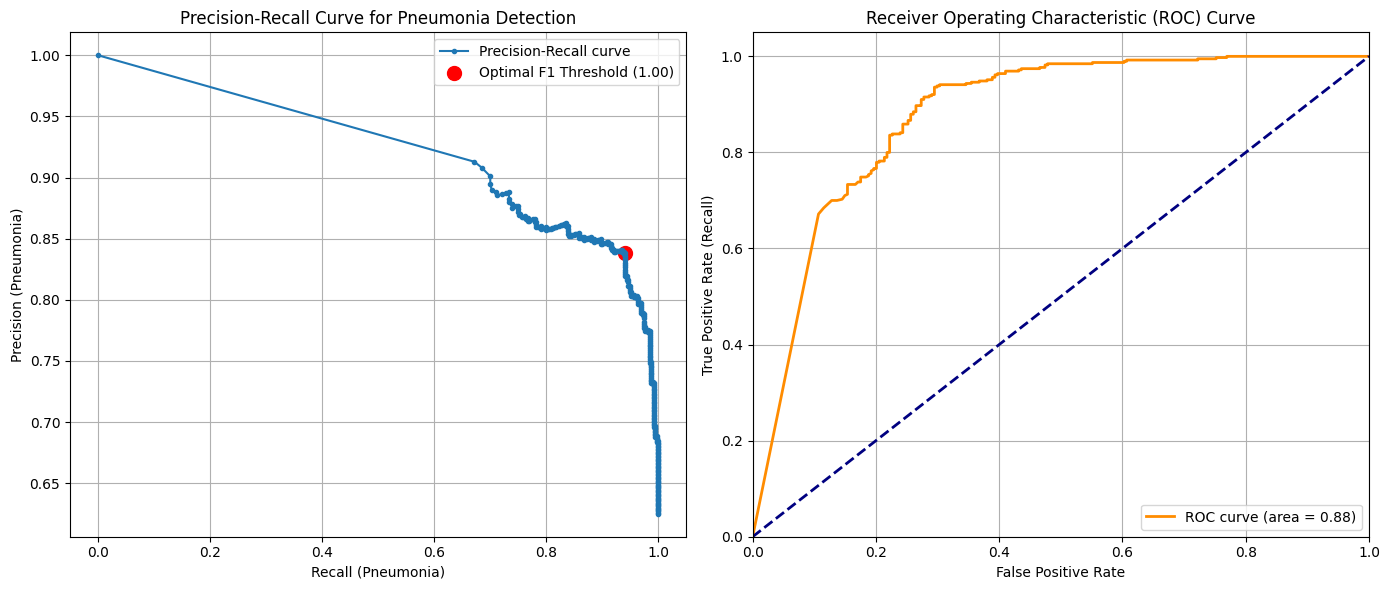


--- Threshold Optimization Complete ---
Final Optimal Threshold (F1-score based): 0.9996
Metrics at this optimal threshold:
  Accuracy: 0.8494
  Precision: 0.8379
  Recall: 0.9410
  F1 score: 0.8865
  Confusion matrix:
[[163  71]
 [ 23 367]]
  Tn: 163.0000
  Fp: 71.0000
  Fn: 23.0000
  Tp: 367.0000


In [92]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, roc_curve, auc

# --- Run Threshold Optimization ---
# Make sure loaded_model_v2 and test_generator_for_optimization are correctly defined
optimization_results = optimize_threshold_v2(
    loaded_model_v2,
    test_generator_for_optimization,
    plot_metrics=True # Set to False if you don't want the plots
)

print("\n--- Threshold Optimization Complete ---")
print(f"Final Optimal Threshold (F1-score based): {optimization_results['optimal_threshold_f1']:.4f}")
print("Metrics at this optimal threshold:")
for key, value in optimization_results['metrics_at_optimal_f1'].items():
    if key != 'confusion_matrix':
        print(f"  {key.replace('_', ' ').capitalize()}: {value:.4f}")
    else:
        print(f"  {key.replace('_', ' ').capitalize()}:\n{np.array(value)}")

## Incorporating optimal threshold

In [93]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# --- Configuration for your data and model ---
# IMPORTANT: REPLACE THESE WITH YOUR ACTUAL DIRECTORY PATHS!
# This should point to your test set or any new data you want to predict on.
#TEST_DATA_DIR = 'path/to/your/test/directory' # e.g., '/Users/youruser/Desktop/pneumonia_dataset/test'

# This should point to the .keras file where your trained Model V2 is saved.
#SAVED_MODEL_PATH = 'path/to/your/saved/Model_V2.keras' # <--- CHANGE THIS PATH!

# Your newly found optimal threshold from the previous optimization step.
OPTIMAL_THRESHOLD = 0.9996 # <--- Your determined optimal threshold!

# Model parameters (must match what your Model V2 was trained with)
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
INPUT_SHAPE = (*IMAGE_SIZE, 1) # (256, 256, 1) for grayscale images

In [94]:
# --- 3. Prepare a generator for the data you want to predict on ---
print("Setting up data generator for predictions...")
predict_datagen = ImageDataGenerator(rescale=1./255) # Same preprocessing (rescaling) as training

# Create the generator. This will read images from your TEST_DATA_DIR.
predict_generator = predict_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,      # Resize images to match model input
    color_mode='grayscale',      # Must match your model's input (1 channel)
    batch_size=BATCH_SIZE,       # Process images in batches
    class_mode='binary',         # 'binary' if folders are 'NORMAL' and 'PNEUMONIA'
    shuffle=False                # CRUCIAL: Do NOT shuffle data for prediction!
                                 # This ensures predictions and true labels (if any) stay aligned.
)
print(f"Generator found {predict_generator.samples} images for prediction.")
print(f"Generator class indices: {predict_generator.class_indices}") # Shows which folder maps to 0/1

Setting up data generator for predictions...
Found 624 images belonging to 2 classes.
Generator found 624 images for prediction.
Generator class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [95]:
# --- 4. Load the trained Model V2 ---
print(f"\nLoading trained model from: {model_path}")
try:
    # tf.keras.models.load_model loads the entire model (architecture + weights)
    loaded_model_v2 = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"ERROR: Could not load model from {model_path}")
    print(f"Please check the path and ensure the file exists. Error details: {e}")
    print("Exiting as prediction cannot proceed without the trained model.")
    exit() # Stop the script if the model can't be loaded


Loading trained model from: /content/cnn_advance_v2.h5


Model loaded successfully.


In [96]:
# --- 5. Get probability predictions from the loaded model ---
print("Generating probability predictions...")

# Calculate the number of steps (batches) needed for prediction
num_samples_to_predict = predict_generator.samples
steps_for_predict = num_samples_to_predict // BATCH_SIZE + (num_samples_to_predict % BATCH_SIZE > 0)

# Use the loaded model to predict probabilities
y_pred_proba = loaded_model_v2.predict(predict_generator, steps=steps_for_predict)

# Important: ensure predictions match the number of samples, as last batch might be partial
y_pred_proba = y_pred_proba[:num_samples_to_predict]

print(f"Generated {len(y_pred_proba)} probability predictions.")
# You can uncomment the line below to see a sample of raw probability outputs
# print("Example raw probabilities (first 10):", y_pred_proba[:10].flatten())

Generating probability predictions...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step
Generated 624 probability predictions.


In [97]:
# --- 6. Apply the optimal threshold to get final binary classifications ---
print(f"Applying optimal threshold of {OPTIMAL_THRESHOLD:.4f} to predictions...")

# Convert probabilities to binary classes based on the optimal threshold
# If probability >= threshold, it's 1 (Pneumonia); otherwise, it's 0 (Normal).
y_pred_final = (y_pred_proba >= OPTIMAL_THRESHOLD).astype(int)

print("\n--- Final Predictions with Optimal Threshold ---")
print("First 10 final predictions (0=NORMAL, 1=PNEUMONIA):")
print(y_pred_final[:10].flatten())

Applying optimal threshold of 0.9996 to predictions...

--- Final Predictions with Optimal Threshold ---
First 10 final predictions (0=NORMAL, 1=PNEUMONIA):
[0 0 1 1 0 0 0 1 0 1]


In [98]:
# --- 7. Evaluate Performance (if you have true labels for these predictions) ---
# If predict_generator is your test_generator, you can get the true labels.
# These true labels must be in the same order as your predictions (due to shuffle=False).

print("\n--- Evaluating Performance with Optimal Threshold ---")
true_labels = predict_generator.classes[predict_generator.index_array]
true_labels = true_labels[:num_samples_to_predict] # Ensure length matches

print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, y_pred_final)
print(cm)
print(f"TN: {cm[0, 0]}, FP: {cm[0, 1]}, FN: {cm[1, 0]}, TP: {cm[1, 1]}")

print("\nClassification Report:")
# target_names should match your class_indices from flow_from_directory
# (e.g., if NORMAL is 0 and PNEUMONIA is 1)
print(classification_report(true_labels, y_pred_final, target_names=['NORMAL', 'PNEUMONIA']))

print("\nProcess complete. Your trained Model V2 is now used with the optimized threshold for classification.")


--- Evaluating Performance with Optimal Threshold ---

Confusion Matrix:
[[161  73]
 [ 23 367]]
TN: 161, FP: 73, FN: 23, TP: 367

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.88      0.69      0.77       234
   PNEUMONIA       0.83      0.94      0.88       390

    accuracy                           0.85       624
   macro avg       0.85      0.81      0.83       624
weighted avg       0.85      0.85      0.84       624


Process complete. Your trained Model V2 is now used with the optimized threshold for classification.


# Conclusions

## Limitations

## Recommendations

## Next Steps